# Preparations

In [41]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/gdrive')

Dir_Path = '/content/gdrive/MyDrive/Workspace/codes_data/TwoStageDCOPF118/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
!pip install pyomo
!apt-get -qq install gcc g++ gfortran git patch wget pkg-config liblapack-dev libmetis-dev
!wget -N -q "https://portal.ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!apt-get install -y -qq glpk-utils

from pyomo.environ import SolverFactory, ConcreteModel, Set, Param, Var, Objective, minimize, Constraint
from pyomo.environ import SolverStatus, TerminationCondition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [43]:
# import libariries
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import cholesky
import pandas as pd
import json
import time
import cvxpy as cp
import random
import math

# Constants

In [44]:
Data_Set_Path = Dir_Path + 'data/'
Results_Path = Dir_Path + 'effectiveness/'
Pre_Train_Path = Dir_Path + 'approach/'
Params_Path = Dir_Path + 'setup/'
Load_Corr_Mat_Dir_Path = Data_Set_Path

RT_Load_Stdev_Factor = 0.05
Scenario_Forecasts_Stdev_Factor = 0.05
Reserve_Price_Factor = 1.5

gamma_res = 10
gamma_gen = 1000
gamma_line = 100
delta_gen = 0.95
delta_line = 0.98

random.seed(123456)
np.random.seed(456123)

# *========== NETWORK TOPOLOGY ==========
listOfNums = json.load(open(Params_Path + 'listOfAllNums', 'r'))
Num_Buses = listOfNums['numBuses']
Num_Gen = listOfNums['numGen']
Num_Lines = listOfNums['numLines']
Slack_Bus_No = listOfNums['slackBusNo']
Slack_Bus_Col = Slack_Bus_No - 1
print('Slack_Bus_No:', Slack_Bus_No)

nominal_loads = np.load(Params_Path + 'predMeanDemand.npy')

# map PQ buses to all buses
# loadList = json.load(open(paramsPath + 'loadList', 'r'))
pos_loads_at_buses = json.load(open(Params_Path + 'posDemandsList', 'r'))

# mask out buses with zero load
zero_loads_at_buses = []
for i in range(Num_Buses):
    idx = i + 1
    if idx not in pos_loads_at_buses:
        zero_loads_at_buses.append(True)
    else:
        zero_loads_at_buses.append(False)

B = np.load(Params_Path + 'fullB.npy')
F = np.load(Params_Path + 'fullF.npy')

Bns = np.delete(B.copy(), Slack_Bus_Col, axis=1)
Fns = np.delete(F.copy(), Slack_Bus_Col, axis=1)
print('Bns:', Bns.shape)
print('Fns:', Fns.shape)

Gen_Price = np.load(Params_Path + 'regGenCost.npy')

# scale reserves cost by suitable factor
Gen_Pos_Res_Price = [i * Reserve_Price_Factor for i in Gen_Price]
Gen_Neg_Res_Price = Gen_Pos_Res_Price
print('Gen_Pos_Res_Price:', len(Gen_Pos_Res_Price))

Gen_Max_Pow = np.load(Params_Path + 'regGenMaxP.npy')
Gen_Min_Pow = np.load(Params_Path + 'regGenMinP.npy')
Flow_Max_Limit = np.load(Params_Path + 'flow_max.npy')
theta_max = np.pi / 2
print('Gen_Max_Pow:', Gen_Max_Pow.shape)
print('Gen_Min_Pow:', Gen_Min_Pow.shape)

Gen_List = json.load(open(Params_Path + 'regGenList', 'r'))
gen_to_bus = [x-1 for x in Gen_List]
nongen_to_bus = []
for x in range(Num_Buses):
    if x not in gen_to_bus:
        nongen_to_bus.append(x)
print('len(Gen_List):', len(Gen_List))
print('gen_to_bus:', gen_to_bus)

ns_bus_list = []
for x in range(Num_Buses):
    if x == Slack_Bus_No-1:
        continue
    ns_bus_list.append(x)
print('len(ns_bus_list):', len(ns_bus_list))
print(ns_bus_list)

Gen_Price = np.array(Gen_Price).reshape(-1, 1)
Gen_Pos_Res_Price = np.array(Gen_Pos_Res_Price).reshape(-1, 1)
Gen_Neg_Res_Price = np.array(Gen_Neg_Res_Price).reshape(-1, 1)
Gen_Max_Pow = np.array(Gen_Max_Pow).reshape(-1, 1)
Gen_Min_Pow = np.array(Gen_Min_Pow).reshape(-1, 1)
Flow_Max_Limit = Flow_Max_Limit .reshape(-1, 1)

Bus_Price = np.zeros((Num_Buses, 1))
Bus_Pos_Res_Price = np.zeros((Num_Buses, 1))
Bus_Neg_Res_Price = np.zeros((Num_Buses, 1))
Bus_Max_Pow = np.zeros((Num_Buses, 1))
Bus_Min_Pow = np.zeros((Num_Buses, 1))

Bus_Price[gen_to_bus, :] = Gen_Price
Bus_Pos_Res_Price[gen_to_bus, :] = Gen_Pos_Res_Price
Bus_Neg_Res_Price[gen_to_bus, :] = Gen_Neg_Res_Price
Bus_Max_Pow[gen_to_bus, :] = Gen_Max_Pow
Bus_Min_Pow[gen_to_bus, :] = Gen_Min_Pow

print('Bus_Price:', Bus_Price[:10,:])
print('Bus_Pos_Res_Price:', Bus_Pos_Res_Price[:10,:])
print('Bus_Neg_Res_Price:', Bus_Neg_Res_Price[:10,:])
print('Bus_Max_Pow:', Bus_Max_Pow[:10,:])
print('Bus_Min_Pow:', Bus_Min_Pow[:10,:])


proj_to_gen_buses = np.eye(Num_Buses)
proj_to_nongen_buses = np.eye(Num_Buses)
for i in range(Num_Buses):
    bus_no = int(i)
    if bus_no not in gen_to_bus:
        print(str(bus_no) + ' is not gen.')
        proj_to_gen_buses[i, i] = 0
    else:
        print(str(bus_no) + ' is gen.')
        proj_to_nongen_buses[i, i] = 0
print('proj_to_gen_buses:', proj_to_gen_buses)
print('proj_to_nongen_buses:', proj_to_nongen_buses)

print(np.sum(proj_to_gen_buses))
print(np.sum(proj_to_nongen_buses))

Slack_Bus_No: 69
Bns: (118, 117)
Fns: (186, 117)
Gen_Pos_Res_Price: 54
Gen_Max_Pow: (54,)
Gen_Min_Pow: (54,)
len(Gen_List): 54
gen_to_bus: [0, 3, 5, 7, 9, 11, 14, 17, 18, 23, 24, 25, 26, 30, 31, 33, 35, 39, 41, 45, 48, 53, 54, 55, 58, 60, 61, 64, 65, 68, 69, 71, 72, 73, 75, 76, 79, 84, 86, 88, 89, 90, 91, 98, 99, 102, 103, 104, 106, 109, 110, 111, 112, 115]
len(ns_bus_list): 117
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
Bus_Price: [[13.1219 ]
 [ 0.     ]
 [ 0.     ]
 [13.1219 ]
 [ 0.     ]
 [13.1219 ]
 [ 0.     ]
 [ 6.44375]
 [ 0.     ]
 [ 3.44375]]
Bus_Pos_R

# Benchmarks


---



## SAA (CVXPY)

In [45]:
# implement saa method using CVXPY
def implement_saa(inputDemands, num_scens, file_name):
    numInstance = inputDemands.shape[0]

    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    all_d_omega = np.zeros((num_scens, Num_Buses, numInstance))
    for t in range(numInstance):
        d_omega = load_sampling(inputDemands[t, :], num_scens)
        all_d_omega[:, :, t] = d_omega

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(Num_Buses)
    scenSet = range(num_scens)

    bus_max_pow = Bus_Max_Pow.reshape(-1, 1)
    bus_min_pow = Bus_Min_Pow.reshape(-1, 1)
    flow_max_limit = Flow_Max_Limit.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['x'] = []
    solns['rp'] = []
    solns['rd'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T

        # define first-stage variables
        x = cp.Variable(shape=(Num_Buses, 1), name='x')
        rp = cp.Variable(shape=(Num_Buses, 1), name='rp')
        rd = cp.Variable(shape=(Num_Buses, 1), name='rd')

        # define second-stage variables
        theta = cp.Variable(shape=(Num_Buses - 1, num_scens), name='theta')
        y = cp.Variable(shape=(Num_Buses, num_scens), name='p')

        # define constraints
        # add operational and phase angle limits and power flow equations
        constraints = [
            # cp.sum(x) == np.sum(inputDemands[t, :]),
            x <= bus_max_pow,
            x >= bus_min_pow,
            x + rp <= bus_max_pow,
            x - rd >= bus_min_pow,
            rp >= np.zeros_like(rp),
            rd >= np.zeros_like(rd),
            theta <= theta_max * np.ones_like(theta),
            theta >= -theta_max * np.ones_like(theta),
            x + y <= np.repeat(bus_max_pow, num_scens, axis=1),
            x + y >= np.repeat(bus_min_pow, num_scens, axis=1),
            Fns @ theta <= np.repeat(flow_max_limit, num_scens, axis=1),
            Fns @ theta >= -np.repeat(flow_max_limit, num_scens, axis=1),
            x + y == Bns @ theta + d_omega
        ]

        # if fsConstrainID == 'addFSBalance':
        #     constraints += [cp.sum(x) == np.sum(inputDemands[t, :])]

        c_gen = sum(Bus_Price[i] * x[i, 0]
                    for i in busSet)

        c_res = sum(Bus_Pos_Res_Price[i] * rp[i, 0] + Bus_Neg_Res_Price[i] * rd[i, 0]
                    for i in busSet)

        c_fs = c_gen + c_res

        c_rcs = (1.0 / num_scens) * sum(
            gamma_res * Bus_Pos_Res_Price[i] * cp.maximum(y[i, scen] - rp[i, 0], 0.0) +
            gamma_res * Bus_Neg_Res_Price[i] * cp.maximum(- rd[i, 0] - y[i, scen], 0.0)
            for scen in scenSet for i in busSet)

        problem = cp.Problem(cp.Minimize(c_fs + c_rcs), constraints)

        problem.solve()

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            sys.exit(0)

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [c_fs.value.item() + c_rcs.value.item()]
        solns['c_gen'] += [c_gen.value.item()]
        solns['c_res'] += [c_res.value.item()]
        solns['c_fs'] += [c_fs.value.item()]
        solns['c_rcs'] += [c_rcs.value.item()]
        solns['x'] += [list(x.value[:, 0])]
        solns['rp'] += [list(rp.value[:, 0])]
        solns['rd'] += [list(rd.value[:, 0])]

        print('Solving tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

        if file_name:
            json.dump(solns, open(Results_Path + file_name, 'w'))

    return solns

## Determine Affine Policy II

In [81]:
def determine_affine_policyII(forecasts, num_scens, file_name=None):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    d_omega = load_sampling(forecasts, num_scens)
    print('d_omega:', d_omega.shape) #d_omega: (100, 118)


    # Google colab
    saa_solver = SolverFactory('ipopt', executable='/content/ipopt')
    # otherwise
    # saa_solver = SolverFactory('ipopt')

    # initialize model
    saa_model = ConcreteModel()

    scen_idx = range(num_scens)
    bus_idx = range(Num_Buses)

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    saa_model.bus_idx = Set(initialize=range(Num_Buses))
    saa_model.line_idx = Set(initialize=range(Num_Lines))
    saa_model.scen_idx = Set(initialize=range(num_scens))
    saa_model.ns_bus_idx = Set(initialize=range(Num_Buses - 1))

    bus_max_pow = Bus_Max_Pow[:, 0]
    bus_min_pow = Bus_Min_Pow[:, 0]
    flow_max_limit = Flow_Max_Limit[:, 0]
    bus_price = Bus_Price[:, 0]
    bus_pos_res_price = Bus_Pos_Res_Price[:, 0]
    bus_neg_reg_price = Bus_Neg_Res_Price[:, 0]
    gen_list = [x - 1 for x in Gen_List]

    # define data
    demandSum_data = [0.0] * num_scens
    dev_data = [0.0] * num_scens

    d_omega_data = dict()
    for u in scen_idx:
        for v in bus_idx:
            d_omega_data[u, v] = 0.

    # saa_model.sumMeanDemand = Param(initialize=0., mutable=True)
    # saa_model.sumDemandDeviations = Param(saa_model.scen_idx, initialize=dev_data, mutable=True)
    saa_model.sumRealTimeDemand = Param(saa_model.scen_idx, initialize=demandSum_data, mutable=True)
    saa_model.d_omega = Param(saa_model.scen_idx, saa_model.bus_idx, initialize=d_omega_data, mutable=True)

    # define functions for bounds and objective rules
    def x_bounds(model, i):
        return bus_min_pow[i], bus_max_pow[i]

    def r_bounds(model, i):
        return 0., bus_max_pow[i] - bus_min_pow[i]

    def nonNegativeReals(model, i, j):
        return 0., np.inf

    def lambda_bounds(model, i):
        return 0., 1.

    def theta_bounds(model, i, scen):
        return -theta_max, theta_max

    def obj_rule(model):
        return sum(bus_price[i] * model.x[i] +
                   bus_pos_res_price[i] * model.rp[i] +
                   bus_neg_reg_price[i] * model.rd[i]
                   for i in model.bus_idx) + \
               (1.0 / num_scens) * gamma_res * sum(bus_pos_res_price[i] * model.posResViol[i, scen] +
                                                    bus_neg_reg_price[i] * model.negResViol[i, scen]
                                                    for scen in model.scen_idx for i in model.bus_idx) + \
               (1.0 / num_scens) * gamma_line * sum(model.lineViol[k, scen] ** 2
                                       for scen in model.scen_idx for k in model.line_idx) + \
               (1.0 / num_scens) * gamma_gen * sum(model.genBoundViol[i, scen] ** 2
                                       for scen in model.scen_idx for i in model.bus_idx)

    # first-stage variables
    saa_model.x = Var(saa_model.bus_idx, bounds=x_bounds)
    saa_model.rp = Var(saa_model.bus_idx, bounds=r_bounds)
    saa_model.rd = Var(saa_model.bus_idx, bounds=r_bounds)
    saa_model.lambd = Var(saa_model.bus_idx, bounds=lambda_bounds)

    # recourse variables
    saa_model.y = Var(saa_model.bus_idx, saa_model.scen_idx)
    saa_model.theta = Var(saa_model.ns_bus_idx, saa_model.scen_idx, bounds=theta_bounds)

    # auxiliary variables
    saa_model.posResViol = Var(saa_model.bus_idx, saa_model.scen_idx, bounds=nonNegativeReals)
    saa_model.negResViol = Var(saa_model.bus_idx, saa_model.scen_idx, bounds=nonNegativeReals)
    saa_model.lineViol = Var(saa_model.line_idx, saa_model.scen_idx, bounds=nonNegativeReals)
    saa_model.genBoundViol = Var(saa_model.bus_idx, saa_model.scen_idx, bounds=nonNegativeReals)

    # objective function
    saa_model.obj = Objective(rule=obj_rule, sense=minimize)

    # first-stage constraints
    def fsConstr2(model, i):
        return model.x[i] + model.rp[i] <= bus_max_pow[i]

    def fsConstr3(model, i):
        return model.x[i] - model.rd[i] >= bus_min_pow[i]

    def fsConstr4(model):
        return sum(model.lambd[i] for i in model.bus_idx) == 1.

    def fsConstr5(model, i):
        if i not in gen_list:
            return model.lambd[i] == 0.0
        else:
            return model.lambd[i] <= 1.0

    saa_model.fsConstr2 = Constraint(saa_model.bus_idx, rule=fsConstr2)
    saa_model.fsConstr3 = Constraint(saa_model.bus_idx, rule=fsConstr3)
    saa_model.fsConstr4 = Constraint(rule=fsConstr4)
    saa_model.fsConstr5 = Constraint(saa_model.bus_idx, rule=fsConstr5)

    # constraints that define p: affine recourse policy without worrying about generation limits
    def recoursePolicyConstr(model, i, scen):

        return model.y[i, scen] == model.lambd[i] * \
               (model.sumRealTimeDemand[scen] - sum(model.x[n] for n in model.bus_idx))

    # power flow equations
    def powFlowConstr(model, i, scen):

        return model.x[i] + model.y[i, scen] == sum(
            Bns[i, k] * model.theta[k, scen] for k in model.ns_bus_idx) + model.d_omega[scen, i]

    # auxiliary constraints for violations of positive and negative reserves
    def posResViolConstr(model, i, scen):
        return model.posResViol[i, scen] >= model.y[i, scen] - model.rp[i]

    def negResViolConstr(model, i, scen):
        return model.negResViol[i, scen] >= - model.rd[i] - model.y[i, scen]

    # auxiliary constraints for line violations
    def lineFlowViolConstr1(model, k, scen):
        return model.lineViol[k, scen] >= sum(Fns[k, j] * model.theta[j, scen] for j in model.ns_bus_idx) - \
               delta_line*flow_max_limit[k]

    def lineFlowViolConstr2(model, k, scen):
        return model.lineViol[k, scen] >= -sum(Fns[k, j] * model.theta[j, scen] for j in model.ns_bus_idx) - \
               delta_line*flow_max_limit[k]

    # generator bounds violation
    # def genBoundViolConstr1(model, i, scen):
    #     return model.genBoundViol[i, scen] >= (model.x[i]+model.y[i, scen]) -\
    #            (bus_min_pow[i] + delta_gen*(bus_max_pow[i]-bus_min_pow[i]))

    # def genBoundViolConstr2(model, i, scen):
    #     return model.genBoundViol[i, scen] >= bus_min_pow[i] + \
    #            (1-delta_gen)*(bus_max_pow[i] - bus_min_pow[i]) - (model.x[i]+model.y[i, scen])
    def genBoundViolConstr1(model, i, scen):
        return model.genBoundViol[i, scen] >= (model.x[i]+model.y[i, scen]) - bus_max_pow[i]

    def genBoundViolConstr2(model, i, scen):
        return model.genBoundViol[i, scen] >= bus_min_pow[i] - (model.x[i]+model.y[i, scen])

    saa_model.rcsConstr1 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=powFlowConstr)
    saa_model.rcsConstr2 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=posResViolConstr)
    saa_model.rcsConstr3 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=negResViolConstr)
    saa_model.rcsConstr4 = Constraint(saa_model.line_idx, saa_model.scen_idx, rule=lineFlowViolConstr1)
    saa_model.rcsConstr5 = Constraint(saa_model.line_idx, saa_model.scen_idx, rule=lineFlowViolConstr2)
    saa_model.rcsConstr6 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=genBoundViolConstr1)
    saa_model.rcsConstr7 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=genBoundViolConstr2)
    saa_model.rcsConstr8 = Constraint(saa_model.bus_idx, saa_model.scen_idx, rule=recoursePolicyConstr)

    # *========= CREATE INSTANCE ==========
    pyo_instance = saa_model.create_instance()

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['x'] = []
    solns['rp'] = []
    solns['rd'] = []
    solns['lambda'] = []
    solns['time'] = []
    solns['lineViol'] = []
    solns['genBoundViol'] = []

    # *========= PASS INTO DATA AND SOLVE==========
    # for t in range(numInstance):
    start_time = time.time()
    # sumPredMeanDemand_iter = forecasts.sum()
    # pyo_instance.sumMeanDemand = sumPredMeanDemand_iter
    sumRealTimeDemand_iter = np.sum(d_omega, axis=1)
    print('sumRealTimeDemand_iter:', sumRealTimeDemand_iter.shape)
    for u in scen_idx:
        # pyo_instance.sumDemandDeviations[u] = sumRealTimeDemand_iter[u] - sumPredMeanDemand_iter
        pyo_instance.sumRealTimeDemand[u] = sumRealTimeDemand_iter[u]
        for v in bus_idx:
            pyo_instance.d_omega[u, v] = d_omega[u, v]

    # *========= SOLVE ==========
    results = saa_solver.solve(pyo_instance, tee=False)
    solve_status = results.solver.status
    tm_cond = results.solver.termination_condition

    if (solve_status != SolverStatus.ok) or (
            tm_cond not in [TerminationCondition.optimal,
                            TerminationCondition.locallyOptimal,
                            TerminationCondition.globallyOptimal]):
        print("GP model not solved to (sub)optimality using Ipopt!!!")
        print("solve_status: ", solve_status)
        print("termination_condition: ", tm_cond)
        sys.exit(0)
    else:
        print("solve status: ", solve_status)
        print("termination condition: ", tm_cond)

    # solutions per instance
    x_soln = []
    rp_soln = []
    rd_soln = []
    lambda_soln = []
    posResViol_soln = []
    negResViol_soln = []
    for v in pyo_instance.bus_idx:
        x_soln += [pyo_instance.x[v].value]

        rp_soln += [pyo_instance.rp[v].value]

        rd_soln += [pyo_instance.rd[v].value]

        lambda_soln += [pyo_instance.lambd[v].value]

        posResViol_soln_per_scen = []
        negResViol_soln_per_scen = []
        for u in pyo_instance.scen_idx:

            posResViol_soln_per_scen.append(pyo_instance.posResViol[v, u].value)

            negResViol_soln_per_scen.append(pyo_instance.negResViol[v, u].value)

        posResViol_soln.append(posResViol_soln_per_scen)
        negResViol_soln.append(negResViol_soln_per_scen)


    solns['x'].append(x_soln)
    solns['rp'].append(rp_soln)
    solns['rd'].append(rd_soln)
    solns['lambda'].append(lambda_soln)

    x_soln = np.array(x_soln)
    rp_soln = np.array(rp_soln)
    rd_soln = np.array(rd_soln)
    lambda_soln = np.array(lambda_soln)
    posResViol_soln = np.array(posResViol_soln)
    negResViol_soln = np.array(negResViol_soln)
    print('x_soln:', x_soln.shape)
    print('rp_soln:', rp_soln.shape)
    print('rd_soln:', rd_soln.shape)
    print('lambda_soln:', lambda_soln.shape)
    print('posResViol_soln:', posResViol_soln.shape)
    print('negResViol_soln:', negResViol_soln.shape)

    c_gen = Bus_Price.T@x_soln
    print('c_gen:', c_gen.shape)

    c_res = Bus_Pos_Res_Price.T@rp_soln + Bus_Neg_Res_Price.T@rd_soln
    print('c_res:', c_res.shape)

    c_fs = np.sum(c_gen + c_res)

    reserve_penalties = Bus_Pos_Res_Price.T@posResViol_soln + Bus_Neg_Res_Price.T@negResViol_soln
    print('reserve_penalties:', reserve_penalties.shape)

    c_rcs = gamma_res * np.sum(reserve_penalties) / num_scens

    solns['c_fs'].append(c_fs)
    solns['c_rcs'].append(c_rcs)
    solns['c_gen'].append(np.sum(c_gen))
    solns['c_res'].append(np.sum(c_res))
    solns['estimateTotalCost'] += [c_fs+c_rcs]

    lineViol_soln = []
    for k in pyo_instance.line_idx:
        for scen in pyo_instance.scen_idx:
            lineViol_soln += [pyo_instance.lineViol[k, scen].value]

    genBoundViol_soln = []
    for n in pyo_instance.bus_idx:
        for scen in pyo_instance.scen_idx:
            genBoundViol_soln += [pyo_instance.genBoundViol[n, scen].value]

    solns['lineViol'].append(sum(lineViol_soln))
    solns['genBoundViol'].append(sum(genBoundViol_soln))

    solns['time'].append(time.time() - start_time)
    print('Solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

    if file_name:
        json.dump(solns, open(Results_Path + file_name, 'w'))

    return solns


## Run Penalty Method II

In [47]:
def run_penalty_methodII(inputDemands, num_scens, lambda_value, file_name=None):
    numInstance = inputDemands.shape[0]

    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    # all_d_omega = np.zeros((num_scens, Num_Buses, numInstance))
    # for t in range(numInstance):
    #     d_omega = load_sampling(inputDemands[t, :], num_scens)
    #     all_d_omega[:, :, t] = d_omega

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(Num_Buses)
    scenSet = range(num_scens)

    bus_max_pow = Bus_Max_Pow.reshape(-1, 1)
    bus_min_pow = Bus_Min_Pow.reshape(-1, 1)
    flow_max_limit = Flow_Max_Limit.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['x'] = []
    solns['rp'] = []
    solns['rd'] = []
    solns['gen_penalties'] = []
    # solns['line_penalties'] = []

    for t in range(numInstance):
        start_time = time.time()
        d_omega = load_sampling(inputDemands[t, :], num_scens).T
        print('d_omega:', d_omega.shape)
        print('total_forecated_demand:', np.sum(inputDemands[t, :]))

        # *====== FOR EACH INSTANCE =======
        # d_omega = all_d_omega[:, :, t].T

        # define first-stage variables
        x = cp.Variable(shape=(Num_Buses, 1), name='x')
        rp = cp.Variable(shape=(Num_Buses, 1), name='rp')
        rd = cp.Variable(shape=(Num_Buses, 1), name='rd')
        # lambd = cp.Variable(shape=(Num_Buses, 1), name='distribution_factor')

        # define second-stage variables
        # theta = cp.Variable(shape=(Num_Buses - 1, num_scens), name='theta')
        # y = cp.Variable(shape=(Num_Buses, num_scens), name='p')
        # xi = cp.Variable(shape=(Num_Buses, num_scens), name='offsets')

        total_rt_demand = np.sum(d_omega, axis=0).reshape(1,-1)
        # total_mismatch = total_rt_demand - cp.sum(x)
        # total_mismatch = total_mismatch.reshape(1, -1)
        if t == 0:
            print('total_rt_demand:', total_rt_demand.shape)
            print('lambda:', lambda_value.shape)

        # define expressions
        # y = cp.multiply(lambda_value, total_mismatch)  # of size (num_gen, num_scens)
        # print('y:', y.shape)
        # lambda_value[i]*total_mismatch[scen]

        # add constraints for affine policy
        # constraints = [
        #     cp.sum(lambd) == 1,
        #     lambd >= np.zeros_like(bus_max_pow),
        #     lambd[nongen_to_bus,:] <= np.zeros(( Num_Buses-Num_Gen, 1))
        # ]

        # define constraints
        # add operational and phase angle limits and power flow equations
        constraints = [
            # cp.sum(x) == np.sum(inputDemands[t, :]),
            x <= bus_max_pow,
            x >= bus_min_pow,
            x + rp <= bus_max_pow,
            x - rd >= bus_min_pow,
            rp >= np.zeros_like(rp),
            rd >= np.zeros_like(rd),
            # theta <= theta_max * np.ones_like(theta),
            # theta >= -theta_max * np.ones_like(theta),
            # theta[slackBusNo - 1, :] == np.zeros(num_scens),
            # x + y <= np.repeat(bus_max_pow, num_scens, axis=1),
            # x + y >= np.repeat(bus_min_pow, num_scens, axis=1),
            # Fns @ theta <= np.repeat(flow_max_limit, num_scens, axis=1),
            # Fns @ theta >= -np.repeat(flow_max_limit, num_scens, axis=1),
            # x + y == Bns @ theta + d_omega
        ]

        # if fsConstrainID == 'addFSBalance':
        # constraints += [cp.sum(x) == np.sum(inputDemands[t, :])]

        # c_gen = sum(Bus_Price[i] * x[i, 0]
        #             for i in busSet)

        # c_res = sum(Bus_Pos_Res_Price[i] * rp[i, 0] + Bus_Neg_Res_Price[i] * rd[i, 0]
        #             for i in busSet)
        gen_cost = Bus_Price.T@x
        print('gen_cost shape:', gen_cost.shape)

        res_cost = Bus_Pos_Res_Price.T@rp + Bus_Neg_Res_Price.T@rd
        print('res_cost shape:', res_cost.shape)

        fs_cost = cp.sum(gen_cost + res_cost)
        print('fs_cost shape:', fs_cost.shape)


        # c_rcs = (1.0 / num_scens) * sum(
        #     gamma_res * Bus_Pos_Res_Price[i] * cp.maximum(lambda_value[i]*(total_rt_demand[0,scen]-cp.sum(x)) - rp[i, 0], 0.0) +
        #     gamma_res * Bus_Neg_Res_Price[i] * cp.maximum(- rd[i, 0] - lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x)), 0.0)
        #     for scen in scenSet for i in busSet)
        reserve_penalties = Bus_Pos_Res_Price.T @ cp.maximum(lambda_value@(total_rt_demand-cp.sum(x)) - rp, np.zeros((Num_Buses, num_scens))) \
                + Bus_Neg_Res_Price.T @ cp.maximum(-rd - lambda_value@(total_rt_demand-cp.sum(x)), np.zeros((Num_Buses, num_scens))) 
        print('reserve_penalties shape:', reserve_penalties.shape) 

        recourse_cost = gamma_res * cp.sum(reserve_penalties) / num_scens
        print('recourse_cost shape:', recourse_cost.shape)

        gen_penalties = cp.maximum(x + lambda_value@(total_rt_demand-cp.sum(x)) - bus_max_pow, np.zeros((Num_Buses, num_scens))) ** 2 \
                        + cp.maximum(bus_min_pow - (x+lambda_value@(total_rt_demand-cp.sum(x))), np.zeros((Num_Buses, num_scens))) ** 2
        print('gen_penalties shape:', gen_penalties.shape)

        gen_penalty_cost = gamma_gen * cp.sum(gen_penalties) / num_scens
        print('gen_penalty_cost shape:', gen_penalty_cost.shape)


        # line_penalties = (1.0 / num_scens) * gamma_line * cp.sum_squares(
        #     cp.maximum(Fns @ theta - np.repeat(flow_max_limit, num_scens, axis=1), np.zeros((Num_Lines, num_scens))) +
        #     cp.maximum(-np.repeat(flow_max_limit, num_scens, axis=1) - Fns @ theta, np.zeros((Num_Lines, num_scens)))
        #     )

        # gen_penalties = (1.0 / num_scens) * gamma_line * cp.sum_squares(
        #     cp.maximum(x + cp.multiply(lambda_value, total_mismatch) - np.repeat(bus_max_pow, num_scens, axis=1), np.zeros((Num_Buses, num_scens))) +
        #     cp.maximum(np.repeat(bus_min_pow, num_scens, axis=1) - (x + cp.multiply(lambda_value, total_mismatch)), np.zeros((Num_Buses, num_scens)))
        #     )
        
        # gen_penalties = (1.0 / num_scens) * gamma_line * sum(
        #     cp.maximum((x[i,0] + lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x))) - bus_max_pow[i], 0.0)**2 +
        #     cp.maximum(bus_min_pow[i] - (x[i,0]+ lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x))), 0.0)**2
        #     for scen in scenSet for i in busSet)

        # problem = cp.Problem(cp.Minimize(c_fs + c_rcs + line_penalties + gen_penalties), constraints)
        problem = cp.Problem(cp.Minimize(fs_cost + recourse_cost + gen_penalty_cost), constraints)

        try:
            problem.solve()
        except:
            problem.solve(solver=cp.ECOS)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            sys.exit(0)

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [fs_cost.value.item() + recourse_cost.value.item()]
        solns['c_gen'] += [gen_cost.value.item()]
        solns['c_res'] += [res_cost.value.item()]
        solns['c_fs'] += [fs_cost.value.item()]
        solns['c_rcs'] += [recourse_cost.value.item()]
        solns['x'] += [list(x.value[:, 0])]
        solns['rp'] += [list(rp.value[:, 0])]
        solns['rd'] += [list(rd.value[:, 0])]
        solns['gen_penalties'] = [gen_penalty_cost.value.item()]
        # solns['line_penalties'] = [line_penalties.value.item()]

        print('Solving tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

        if file_name:
            json.dump(solns, open(Results_Path + file_name, 'w'))

    return solns

In [48]:
def run_penalty_methodII_limit_flow(inputDemands, num_scens, lambda_value, file_name=None):
    numInstance = inputDemands.shape[0]

    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    # all_d_omega = np.zeros((num_scens, Num_Buses, numInstance))
    # for t in range(numInstance):
    #     d_omega = load_sampling(inputDemands[t, :], num_scens)
    #     all_d_omega[:, :, t] = d_omega

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(Num_Buses)
    scenSet = range(num_scens)

    bus_max_pow = Bus_Max_Pow.reshape(-1, 1)
    bus_min_pow = Bus_Min_Pow.reshape(-1, 1)
    flow_max_limit = Flow_Max_Limit.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['x'] = []
    solns['rp'] = []
    solns['rd'] = []
    solns['gen_penalties'] = []
    solns['line_penalties'] = []

    for t in range(numInstance):
        start_time = time.time()
        d_omega = load_sampling(inputDemands[t, :], num_scens).T
        print('d_omega:', d_omega.shape)
        print('total_forecated_demand:', np.sum(inputDemands[t, :]))

        # *====== FOR EACH INSTANCE =======
        # d_omega = all_d_omega[:, :, t].T

        # define first-stage variables
        x = cp.Variable(shape=(Num_Buses, 1), name='x')
        rp = cp.Variable(shape=(Num_Buses, 1), name='rp')
        rd = cp.Variable(shape=(Num_Buses, 1), name='rd')
        # lambd = cp.Variable(shape=(Num_Buses, 1), name='distribution_factor')

        # define second-stage variables
        theta = cp.Variable(shape=(Num_Buses - 1, num_scens), name='theta')
        # y = cp.Variable(shape=(Num_Buses, num_scens), name='p')
        # xi = cp.Variable(shape=(Num_Buses, num_scens), name='offsets')

        total_rt_demand = np.sum(d_omega, axis=0).reshape(1,-1)
        # total_mismatch = total_rt_demand - cp.sum(x)
        # total_mismatch = total_mismatch.reshape(1, -1)
        if t == 0:
            print('total_rt_demand:', total_rt_demand.shape)
            print('lambda:', lambda_value.shape)

        # define expressions
        # y = cp.multiply(lambda_value, total_mismatch)  # of size (num_gen, num_scens)
        # print('y:', y.shape)
        # lambda_value[i]*total_mismatch[scen]

        # add constraints for affine policy
        # constraints = [
        #     cp.sum(lambd) == 1,
        #     lambd >= np.zeros_like(bus_max_pow),
        #     lambd[nongen_to_bus,:] <= np.zeros(( Num_Buses-Num_Gen, 1))
        # ]

        # define constraints
        # add operational and phase angle limits and power flow equations
        constraints = [
            # cp.sum(x) == np.sum(inputDemands[t, :]),
            x <= bus_max_pow,
            x >= bus_min_pow,
            x + rp <= bus_max_pow,
            x - rd >= bus_min_pow,
            rp >= np.zeros_like(rp),
            rd >= np.zeros_like(rd),
            theta <= theta_max * np.ones_like(theta),
            theta >= -theta_max * np.ones_like(theta),
            # theta[slackBusNo - 1, :] == np.zeros(num_scens),
            # x + y <= np.repeat(bus_max_pow, num_scens, axis=1),
            # x + y >= np.repeat(bus_min_pow, num_scens, axis=1),
            # Fns @ theta <= np.repeat(flow_max_limit, num_scens, axis=1),
            # Fns @ theta >= -np.repeat(flow_max_limit, num_scens, axis=1),
            x + lambda_value@(total_rt_demand-cp.sum(x)) == Bns @ theta + d_omega
        ]

        # if fsConstrainID == 'addFSBalance':
        # constraints += [cp.sum(x) == np.sum(inputDemands[t, :])]

        # c_gen = sum(Bus_Price[i] * x[i, 0]
        #             for i in busSet)

        # c_res = sum(Bus_Pos_Res_Price[i] * rp[i, 0] + Bus_Neg_Res_Price[i] * rd[i, 0]
        #             for i in busSet)
        gen_cost = Bus_Price.T@x
        print('gen_cost shape:', gen_cost.shape)

        res_cost = Bus_Pos_Res_Price.T@rp + Bus_Neg_Res_Price.T@rd
        print('res_cost shape:', res_cost.shape)

        fs_cost = cp.sum(gen_cost + res_cost)
        print('fs_cost shape:', fs_cost.shape)


        # c_rcs = (1.0 / num_scens) * sum(
        #     gamma_res * Bus_Pos_Res_Price[i] * cp.maximum(lambda_value[i]*(total_rt_demand[0,scen]-cp.sum(x)) - rp[i, 0], 0.0) +
        #     gamma_res * Bus_Neg_Res_Price[i] * cp.maximum(- rd[i, 0] - lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x)), 0.0)
        #     for scen in scenSet for i in busSet)
        reserve_penalties = Bus_Pos_Res_Price.T @ cp.maximum(lambda_value@(total_rt_demand-cp.sum(x)) - rp, np.zeros((Num_Buses, num_scens))) \
                + Bus_Neg_Res_Price.T @ cp.maximum(-rd - lambda_value@(total_rt_demand-cp.sum(x)), np.zeros((Num_Buses, num_scens))) 
        print('reserve_penalties shape:', reserve_penalties.shape) 

        recourse_cost = gamma_res * cp.sum(reserve_penalties) / num_scens
        print('recourse_cost shape:', recourse_cost.shape)

        gen_penalties = cp.maximum(x + lambda_value@(total_rt_demand-cp.sum(x)) - bus_max_pow, np.zeros((Num_Buses, num_scens))) ** 2 \
                        + cp.maximum(bus_min_pow - (x+lambda_value@(total_rt_demand-cp.sum(x))), np.zeros((Num_Buses, num_scens))) ** 2
        print('gen_penalties shape:', gen_penalties.shape)

        gen_penalty_cost = gamma_gen * cp.sum(gen_penalties) / num_scens
        print('gen_penalty_cost shape:', gen_penalty_cost.shape)


        # line_penalties = (1.0 / num_scens) * gamma_line * cp.sum_squares(
        #     cp.maximum(Fns @ theta - np.repeat(flow_max_limit, num_scens, axis=1), np.zeros((Num_Lines, num_scens))) +
        #     cp.maximum(-np.repeat(flow_max_limit, num_scens, axis=1) - Fns @ theta, np.zeros((Num_Lines, num_scens)))
        #     )
        line_penalties = cp.maximum(Fns @ theta - np.repeat(flow_max_limit, num_scens, axis=1), np.zeros((Num_Lines, num_scens))) ** 2 \
                        + cp.maximum(-np.repeat(flow_max_limit, num_scens, axis=1) - Fns @ theta, np.zeros((Num_Lines, num_scens))) ** 2

        line_penalty_cost = gamma_line * cp.sum(line_penalties) / num_scens
        print('line_penalty_cost shape:', line_penalty_cost.shape)

        # gen_penalties = (1.0 / num_scens) * gamma_line * cp.sum_squares(
        #     cp.maximum(x + cp.multiply(lambda_value, total_mismatch) - np.repeat(bus_max_pow, num_scens, axis=1), np.zeros((Num_Buses, num_scens))) +
        #     cp.maximum(np.repeat(bus_min_pow, num_scens, axis=1) - (x + cp.multiply(lambda_value, total_mismatch)), np.zeros((Num_Buses, num_scens)))
        #     )
        
        # gen_penalties = (1.0 / num_scens) * gamma_line * sum(
        #     cp.maximum((x[i,0] + lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x))) - bus_max_pow[i], 0.0)**2 +
        #     cp.maximum(bus_min_pow[i] - (x[i,0]+ lambda_value[i,0]*(total_rt_demand[0,scen]-cp.sum(x))), 0.0)**2
        #     for scen in scenSet for i in busSet)

        # problem = cp.Problem(cp.Minimize(c_fs + c_rcs + line_penalties + gen_penalties), constraints)
        problem = cp.Problem(cp.Minimize(fs_cost + recourse_cost + gen_penalty_cost + line_penalty_cost), constraints)

        try:
            problem.solve()
        except:
            problem.solve(solver=cp.ECOS)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            sys.exit(0)

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [fs_cost.value.item() + recourse_cost.value.item()]
        solns['c_gen'] += [gen_cost.value.item()]
        solns['c_res'] += [res_cost.value.item()]
        solns['c_fs'] += [fs_cost.value.item()]
        solns['c_rcs'] += [recourse_cost.value.item()]
        solns['x'] += [list(x.value[:, 0])]
        solns['rp'] += [list(rp.value[:, 0])]
        solns['rd'] += [list(rd.value[:, 0])]
        solns['gen_penalties'] = [gen_penalty_cost.value.item()]
        solns['line_penalties'] = [line_penalty_cost.value.item()]

        print('Solving tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

        if file_name:
            json.dump(solns, open(Results_Path + file_name, 'w'))

    return solns

## Recourse problem

In [49]:
def solve_recourse(inputDemands, all_d_omega, fs_soln,
                   file_name, return_rcsSolns=False):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = inputDemands.shape[0]
    numScenarios = all_d_omega.shape[0]

    x_soln = np.array(fs_soln['x']).reshape(-1,1)
    rp_soln = np.array(fs_soln['rp']).reshape(-1,1)
    rd_soln = np.array(fs_soln['rd']).reshape(-1,1)
    fsCost = np.array(fs_soln['c_fs']).flatten()
    print('x_soln:', x_soln.shape)
    print('rp_soln:', rp_soln.shape)
    print('rd_soln:', rd_soln.shape)
    print('fsCost:', fsCost.shape)

    # dictionary to store recourse solutions in case return_rcsSolns is true
    rcsSolns = dict()
    rcsSolns['d_omega'] = np.zeros((Num_Buses, numInstance))
    rcsSolns['theta'] = []
    rcsSolns['y'] = []
    if return_rcsSolns:
        # there will only be a single scenario for each instance under this setting
        rcsSolns['d_omega'] = all_d_omega[0, :, :]

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(Num_Buses)
    scenSet = range(numScenarios)

    bus_max_pow = Bus_Max_Pow.reshape(-1, 1)
    bus_min_pow = Bus_Min_Pow.reshape(-1, 1)
    flow_max_limit = Flow_Max_Limit.reshape(-1, 1)

    # dictionary to store results for all instances
    evalSolns = dict()
    evalSolns['Status'] = []
    evalSolns['fsCost'] = []
    evalSolns['rcsCost'] = []
    evalSolns['evaluateTotalCost'] = []
    evalSolns['pos_res_cost'] = []
    evalSolns['neg_res_cost'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T
        # print('d_omega:', d_omega.shape)

        # recourse variables
        theta = cp.Variable(shape=(Num_Buses-1, numScenarios), name='theta')
        y = cp.Variable(shape=(Num_Buses, numScenarios), name='y')

        constraints = [
            theta <= theta_max * np.ones_like(theta),
            theta >= -theta_max * np.ones_like(theta),
            x_soln[t:t + 1, :].T + y <= np.repeat(bus_max_pow, numScenarios, axis=1),
            x_soln[t:t + 1, :].T + y >= np.repeat(bus_min_pow, numScenarios, axis=1),
            Fns @ theta <= np.repeat(flow_max_limit, numScenarios, axis=1),
            Fns @ theta >= -np.repeat(flow_max_limit, numScenarios, axis=1),
            x_soln[t:t + 1, :].T + y == Bns @ theta + d_omega
        ]

        # cost = (1.0 / numScenarios) * sum(
        #     gamma_res * Bus_Pos_Res_Price[i] * cp.maximum(y[i, scen] - rp_soln[t, i], 0.0) +
        #     gamma_res * Bus_Neg_Res_Price[i] * cp.maximum(- rd_soln[t, i] - y[i, scen], 0.0)
        #     for scen in scenSet for i in busSet)
        
        # reserve_penalties = Bus_Pos_Res_Price.T @ cp.maximum(y - rp_soln, np.zeros((Num_Buses, numScenarios))) \
        #         + Bus_Neg_Res_Price.T @ cp.maximum(-rd_soln - y, np.zeros((Num_Buses, numScenarios))) 
        # print('reserve_penalties shape:', reserve_penalties.shape) 

        # recourse_cost = gamma_res * cp.sum(reserve_penalties) / numScenarios
        # print('recourse_cost shape:', recourse_cost.shape)

        pos_res_cost = Bus_Pos_Res_Price.T @ cp.maximum(y - rp_soln, np.zeros((Num_Buses, numScenarios)))
        neg_res_cost = Bus_Neg_Res_Price.T @ cp.maximum(-rd_soln - y, np.zeros((Num_Buses, numScenarios))) 
        print('pos_res_cost shape:', pos_res_cost.shape) 

        recourse_cost = gamma_res * cp.sum(pos_res_cost+neg_res_cost) / numScenarios
        print('recourse_cost shape:', recourse_cost.shape)

        problem = cp.Problem(cp.Minimize(recourse_cost), constraints)

        problem.solve(solver=cp.ECOS)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)

            evalSolns['Status'] += [str(problem.status)]
            evalSolns['fsCost'] += [fsCost[t]]
            evalSolns['rcsCost'] += [np.inf]
            evalSolns['evaluateTotalCost'] += [np.inf]
            evalSolns['pos_res_cost'] += [np.inf]
            evalSolns['neg_res_cost'] += [np.inf]

            if return_rcsSolns:
                rcsSolns['theta'].append([np.inf] * Num_Buses)
                rcsSolns['y'].append([np.inf] * Num_Buses)

            # sys.exit(0)
            continue

        print("Instance: %d Problem status: %s " % (t, problem.status))

        evalSolns['Status'] += [str(problem.status)]
        evalSolns['fsCost'] += [fsCost[t]]
        evalSolns['rcsCost'] += [recourse_cost.value.item()]
        evalSolns['evaluateTotalCost'] += [fsCost[t] + recourse_cost.value.item()]
        evalSolns['pos_res_cost'] += [cp.sum(pos_res_cost).value.item()/numScenarios]
        evalSolns['neg_res_cost'] += [cp.sum(neg_res_cost).value.item()/numScenarios]

        if return_rcsSolns:
            rcsSolns['theta'].append(list(theta.value[:, 0]))
            rcsSolns['y'].append(list(y.value[:, 0]))

        print('Evaluation tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

        if file_name:
            json.dump(evalSolns, open(Results_Path + file_name, 'w'))

    return evalSolns, rcsSolns

# Set up Pytorch

## Imports & Constants

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import pad, relu
import torch.optim as optim

torch.manual_seed(8899)

TORCH_GENERATION = False

PRE_TRAINING = False
TRAINING = False

RUN_NEURAL_SOLVER = False
EVAL_NEURAL = False

RUN_SAA = False
EVAL_SAA = False

RUN_PENALTY_METHODII_NOMINAL = True
RUN_PENALTY_METHODII = True
EVAL_PENALTY_METHODII = True


In [51]:
# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
# data to be used in training process
B_ts = torch.tensor(B).float().to(device)
Bns_ts = torch.tensor(Bns).float().to(device)

Gen_Price_ts = torch.tensor(Gen_Price).float().to(device).reshape(-1, 1)
Gen_Pos_Res_Price_ts = torch.tensor(Gen_Pos_Res_Price).float().to(device).reshape(-1, 1)
Gen_Neg_Res_Price_ts = torch.tensor(Gen_Neg_Res_Price).float().to(device).reshape(-1, 1)
Bus_Pos_Res_Price_ts = torch.tensor(Bus_Pos_Res_Price).float().to(device).reshape(-1, 1)
Bus_Neg_Res_Price_ts = torch.tensor(Bus_Neg_Res_Price).float().to(device).reshape(-1, 1)
Gen_Max_Pow_ts = torch.tensor(Gen_Max_Pow).float().to(device).reshape(-1, 1)
Gen_Min_Pow_ts = torch.tensor(Gen_Min_Pow).float().to(device).reshape(-1, 1)
Bus_Max_Pow_ts = torch.tensor(Bus_Max_Pow).float().to(device).reshape(-1, 1)
Bus_Min_Pow_ts = torch.tensor(Bus_Min_Pow).float().to(device).reshape(-1, 1)

Load_Corr_Mat = np.load(Load_Corr_Mat_Dir_Path + 'demandCorrMat.npy')
Load_Corr_Mat_ts = torch.tensor(Load_Corr_Mat).float().to(device)

In [53]:
rcsG = np.block([
    [Fns],
    [-Fns],
    [np.eye(Num_Buses - 1)],
    [-np.eye(Num_Buses - 1)]
])

rcs_h = np.block([
    [Flow_Max_Limit.reshape(-1, 1)],
    [Flow_Max_Limit.reshape(-1, 1)],
    [theta_max * np.ones((Num_Buses - 1, 1))],
    [theta_max * np.ones((Num_Buses - 1, 1))]
])

rcsG_ts = torch.tensor(rcsG).float().to(device)
rcs_h_ts = torch.tensor(rcs_h).float().to(device)

## Functions for visualization

In [64]:
def visualize_train_loss(train_hist, fig_name, yplot='log10'):
    Xrange = range(len(train_hist['train_losses']))

    fig = plt.figure(figsize=(7, 4))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    if yplot == 'log10':
        ax.plot(Xrange, np.log10(train_hist['train_losses']), label='train loss')
        ax.set_ylabel('log10(train loss)', fontsize=20)

    elif yplot == 'plain':
        ax.plot(Xrange, train_hist['train_losses'], label='train loss')
        ax.set_ylabel('train loss', fontsize=20)

    ax.set_xlabel('training epochs', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    fig.tight_layout()
    plt.savefig(Results_Path + fig_name)
    plt.show()

In [65]:
def visualize(x, y, label_name, xlabel_name, ylabel_name):

    fig = plt.figure(figsize=(7, 4))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, label=label_name)
    ax.set_ylabel(ylabel_name, fontsize=20)
    ax.set_xlabel(xlabel_name, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [76]:
def visualize_bar(x, y, label_name, xlabel_name, ylabel_name):

    fig = plt.figure(figsize=(7, 4))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x, y, label=label_name, width = 0.7)
    ax.set_ylabel(ylabel_name, fontsize=20)
    ax.set_xlabel(xlabel_name, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [67]:
def visualize_step(x, y, label_name, xlabel_name, ylabel_name):

    fig = plt.figure(figsize=(7, 4))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    ax.step(x, y, label=label_name)
    ax.set_ylabel(ylabel_name, fontsize=20)
    ax.set_xlabel(xlabel_name, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [56]:
def visualize2(x, y1, y2, label_name1, 
               label_name2, xlabel_name, ylabel_name):

    fig = plt.figure(figsize=(7, 4))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y1, label=label_name1, color='orangered',
            ls='-', lw=2,
            marker='s', mfc='none', ms=8)
    ax.plot(x, y2, label=label_name2, color='royalblue',
            ls='-', lw=2,
            marker='^', mfc='none', ms=8)
    ax.set_ylabel(ylabel_name, fontsize=20)
    ax.set_xlabel(xlabel_name, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

## Training data set

---



### Customize *torch.Dataset*

In [57]:
class CustomTorchDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return self.samples[idx, :]

### Load sampling

In [58]:
# generate {num_scens} real-time load scenarios for a particular instance of scenario forecast
def load_sampling(load_mean, num_scens):
    assert len(load_mean) == Num_Buses

    # standard deviation of loads/demands. keep this small enough to be realistic
    load_stdev = RT_Load_Stdev_Factor * load_mean
    # for zero stdev, set them to be small, i.e., 0.1
    load_stdev = np.where(load_stdev < 1e-5, 0.1, load_stdev)

    # randomly generated correlation matrix for the demands
    load_corr_mat = np.load(Load_Corr_Mat_Dir_Path + 'demandCorrMat.npy')

    load_cov_mat = np.diag(load_stdev) @ load_corr_mat @ np.diag(load_stdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    load_cov_mat_chol = cholesky(load_cov_mat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    std_normal = np.random.multivariate_normal([0.] * Num_Buses, np.eye(Num_Buses), num_scens)
    load_scens = load_cov_mat_chol @ std_normal.T + np.repeat(load_mean.reshape(-1, 1), num_scens, axis=-1)
    load_scens = load_scens.T

    # set zero load to be zero
    load_scens[:, zero_loads_at_buses] = 0.

    return load_scens


# generate {num_scens} real-time load scenarios for a particular instance of scenario forecast
def instances_sampling(load_mean, num_instances, stddev_factor):
    assert len(load_mean) == Num_Buses

    # standard deviation of loads/demands. keep this small enough to be realistic
    load_stdev = stddev_factor * load_mean
    # for zero stdev, set them to be small, i.e., 0.1
    load_stdev = np.where(load_stdev < 1e-5, 0.1, load_stdev)

    # randomly generated correlation matrix for the demands
    load_corr_mat = np.load(Load_Corr_Mat_Dir_Path + 'demandCorrMat.npy')

    load_cov_mat = np.diag(load_stdev) @ load_corr_mat @ np.diag(load_stdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    load_cov_mat_chol = cholesky(load_cov_mat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    std_normal = np.random.multivariate_normal([0.] * Num_Buses, np.eye(Num_Buses), num_instances)
    load_scens = load_cov_mat_chol @ std_normal.T + np.repeat(load_mean.reshape(-1, 1), num_instances, axis=-1)
    load_scens = load_scens.T

    # set zero load to be zero
    load_scens[:, zero_loads_at_buses] = 0.

    return load_scens

### Generate labels

In [59]:
def generate_labels(inputDemands, num_scens=1):
    numInstance = inputDemands.shape[0]

    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    all_d_omega = np.zeros((num_scens, Num_Buses, numInstance))
    for t in range(numInstance):
        d_omega = load_sampling(inputDemands[t, :], 1)
        all_d_omega[:, :, t] = d_omega

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(Num_Buses)
    scenSet = range(num_scens)

    bus_max_pow = Bus_Max_Pow.reshape(-1, 1)
    bus_min_pow = Bus_Min_Pow.reshape(-1, 1)
    flow_max_limit = Flow_Max_Limit.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['x'] = []
    solns['rp'] = []
    solns['rd'] = []
    solns['net_load'] = []
    solns['theta'] = []
    solns['y'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T

        net_load = d_omega - inputDemands[t:t+1, :].T
        if t == 0:
            print('net_load:', net_load.shape)

        # define first-stage variables
        x = cp.Variable(shape=(Num_Buses, 1), name='x')
        rp = cp.Variable(shape=(Num_Buses, 1), name='rp')
        rd = cp.Variable(shape=(Num_Buses, 1), name='rd')

        # define second-stage variables
        theta = cp.Variable(shape=(Num_Buses - 1, num_scens), name='theta')
        y = cp.Variable(shape=(Num_Buses, num_scens), name='p')

        # define constraints
        # add operational and phase angle limits and power flow equations
        constraints = [
            # cp.sum(x) == np.sum(inputDemands[t, :]),
            x <= bus_max_pow,
            x >= bus_min_pow,
            x + rp <= bus_max_pow,
            x - rd >= bus_min_pow,
            rp >= np.zeros_like(rp),
            rd >= np.zeros_like(rd),
            theta <= theta_max * np.ones_like(theta),
            theta >= -theta_max * np.ones_like(theta),
            x + y <= np.repeat(bus_max_pow, num_scens, axis=1),
            x + y >= np.repeat(bus_min_pow, num_scens, axis=1),
            Fns @ theta <= np.repeat(flow_max_limit, num_scens, axis=1),
            Fns @ theta >= -np.repeat(flow_max_limit, num_scens, axis=1),
            x + y == Bns @ theta + d_omega
        ]

        # if fsConstrainID == 'addFSBalance':
        #     constraints += [cp.sum(x) == np.sum(inputDemands[t, :])]

        c_gen = sum(Bus_Price[i] * x[i, 0]
                    for i in busSet)

        c_res = sum(Bus_Pos_Res_Price[i] * rp[i, 0] + Bus_Neg_Res_Price[i] * rd[i, 0]
                    for i in busSet)

        c_fs = c_gen + c_res

        c_rcs = (1.0 / num_scens) * sum(
            gamma_res * Bus_Pos_Res_Price[i] * cp.maximum(y[i, scen] - rp[i, 0], 0.0) +
            gamma_res * Bus_Neg_Res_Price[i] * cp.maximum(- rd[i, 0] - y[i, scen], 0.0)
            for scen in scenSet for i in busSet)

        problem = cp.Problem(cp.Minimize(c_fs + c_rcs), constraints)

        problem.solve()

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            sys.exit(0)

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [c_fs.value.item() + c_rcs.value.item()]
        solns['c_gen'] += [c_gen.value.item()]
        solns['c_res'] += [c_res.value.item()]
        solns['c_fs'] += [c_fs.value.item()]
        solns['c_rcs'] += [c_rcs.value.item()]
        solns['x'] += [list(x.value[:, 0])]
        solns['rp'] += [list(rp.value[:, 0])]
        solns['rd'] += [list(rd.value[:, 0])]
        solns['net_load'] += [list(net_load[:, 0])]
        solns['theta'] += [list(theta.value[:, 0])]
        solns['y'] += [list(y.value[:, 0])]

        print('Solving tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

    x_data = np.array(solns['x'])
    rp_data = np.array(solns['rp'])
    rd_data = np.array(solns['rd'])
    net_load_data = np.array(solns['net_load'])
    theta_data = np.array(solns['theta'])
    y_data = np.array(solns['y'])

    print('x_data:', x_data.shape)
    print('rp_data:', rp_data.shape)
    print('rd_data:', rd_data.shape)
    print('net_load_data:', net_load_data.shape)
    print('theta_data:', theta_data.shape)
    print('y_data:', y_data.shape)

    pre_train_fs_data = np.concatenate([inputDemands, x_data, rp_data, rd_data], axis=1)
    pre_train_rcs_data = np.concatenate([net_load_data, y_data, theta_data, rp_data, rd_data], axis=1)

    print('pre_train_fs_data:', pre_train_fs_data.shape)
    print('pre_train_rcs_data:', pre_train_rcs_data.shape)

    np.save(Data_Set_Path + 'pre_train_fs_data.npy', pre_train_fs_data)
    np.save(Data_Set_Path + 'pre_train_rcs_data.npy', pre_train_rcs_data)

    return pre_train_fs_data, pre_train_rcs_data

### Get data ready

In [60]:
# Generate all datasets if needed
if TORCH_GENERATION:
    train_points_num = 60000
    pre_train_points_num = 100
    test_points_num = 1000

    Nt = train_points_num + pre_train_points_num + test_points_num

    all_instances = instances_sampling(nominal_loads, Nt, Scenario_Forecasts_Stdev_Factor)
    train_instances = all_instances[:-test_points_num, :]

    test_set = all_instances[-test_points_num:, :]
    train_set = train_instances[:-pre_train_points_num, :]
    pretrain_set = train_instances[-pre_train_points_num:, :]
    print('train_set:', train_set.shape)
    print('test_set:', test_set.shape)
    print('pretrain_set:', pretrain_set.shape)

    np.save(Data_Set_Path + 'all_instances.npy', all_instances)
    np.save(Data_Set_Path + 'train_instances.npy', train_instances)
    np.save(Data_Set_Path + 'test_set.npy', test_set)
    np.save(Data_Set_Path + 'train_set.npy', train_set)
    np.save(Data_Set_Path + 'pretrain_set.npy', pretrain_set)

    pre_train_fs_data, pre_train_rcs_data = generate_labels(pretrain_set)

    # generate a common set of MC scenarios
    test_scens_num = 100
    common_MCscenarios = np.zeros((test_scens_num, Num_Buses, test_points_num))
    for t in range(test_points_num):
        scens = load_sampling(test_set[t, :], test_scens_num)
        common_MCscenarios[:, :, t] = scens

    np.save(Data_Set_Path + 'common_MCscenarios_K100.npy', common_MCscenarios)

else:
    # all_instances = np.load(Data_Set_Path + 'all_instances.npy')
    # train_instances = np.load(Data_Set_Path + 'train_instances.npy')

    test_set = np.load(Data_Set_Path + 'test_set.npy')
    # train_set = np.load(Data_Set_Path + 'train_set.npy')
    # pretrain_set = np.load(Data_Set_Path + 'pretrain_set.npy')

    # pre_train_fs_data = np.load(Data_Set_Path + 'pre_train_fs_data.npy')
    # pre_train_rcs_data = np.load(Data_Set_Path + 'pre_train_rcs_data.npy')

    common_MCscenarios = np.load(Data_Set_Path + 'common_MCscenarios_K100.npy')

# inputScalingFactor = np.max(train_instances)
# print('inputScalingFactor:', inputScalingFactor)


## Run Methods

### Nominal Loads

In [83]:
if RUN_PENALTY_METHODII_NOMINAL:
    penalty_methodII_nominal_soln = determine_affine_policyII(nominal_loads.flatten(), num_scens=100, 
                                                              file_name='penalty_methodII_nominal_soln_K100')

    lambda_soln = np.array(penalty_methodII_nominal_soln['lambda'])
    print('lambda_soln:', lambda_soln.shape)

d_omega: (100, 118)
sumRealTimeDemand_iter: (100,)
solve status:  ok
termination condition:  optimal
x_soln: (118,)
rp_soln: (118,)
rd_soln: (118,)
lambda_soln: (118,)
posResViol_soln: (118, 100)
negResViol_soln: (118, 100)
c_gen: (1,)
c_res: (1,)
reserve_penalties: (1, 100)
Solving tims is 48.27 minutes.
lambda_soln: (1, 118)


dict_keys(['estimateTotalCost', 'c_gen', 'c_res', 'c_fs', 'c_rcs', 'x', 'rp', 'rd', 'lambda', 'time', 'lineViol', 'genBoundViol'])
lambda_soln: (1, 118)


<ipython-input-76-af0e9bcea6c9>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


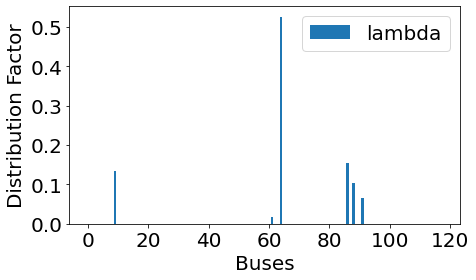

x_pII_nominal shape: (1, 118)


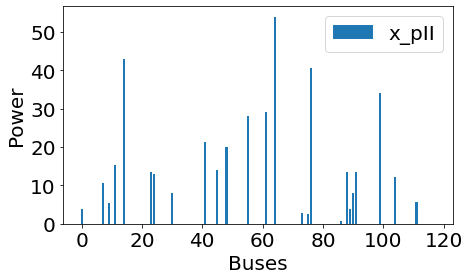

Results on nominal loads:
total cost [3009.9805730300623]
gen cost [2915.1229703944928]
res cost [80.0913292544628]
recourse cost [14.766273381106794]
lineViol [3.054419171769759]
genBoundViol [0.20915186805800104]


In [84]:
# sanity check
penalty_methodII_nominal_soln = json.load(open(Results_Path + 'penalty_methodII_nominal_soln_K100', 'r'))
print(penalty_methodII_nominal_soln.keys())

lambda_soln = np.array(penalty_methodII_nominal_soln['lambda'])
print('lambda_soln:', lambda_soln.shape)
visualize_bar(range(Num_Buses), lambda_soln[0,:], 'lambda', 'Buses', 'Distribution Factor')

x_pII_nominal = np.array(penalty_methodII_nominal_soln['x'])
print('x_pII_nominal shape:', x_pII_nominal.shape)
visualize_bar(range(Num_Buses), x_pII_nominal[0,:], 'x_pII', 'Buses', 'Power')

print('Results on nominal loads:')
print("total cost", penalty_methodII_nominal_soln['estimateTotalCost'])
print("gen cost", penalty_methodII_nominal_soln['c_gen'])
print("res cost", penalty_methodII_nominal_soln['c_res'])
print("recourse cost", penalty_methodII_nominal_soln['c_rcs'])
print("lineViol", penalty_methodII_nominal_soln['lineViol'])
print("genBoundViol", penalty_methodII_nominal_soln['genBoundViol'])

### Testing

In [85]:
if RUN_PENALTY_METHODII:
    # consider the training time budget, can use 50 scenarios for solving
    penalty_methodII_soln_results = run_penalty_methodII(test_set[:1, :], num_scens=100, 
                                                         lambda_value=lambda_soln.T, 
                                                         file_name='penalty_methodII_soln_K100')

d_omega: (118, 100)
total_forecated_demand: 425.4987051375464
total_rt_demand: (1, 100)
lambda: (118, 1)
gen_cost shape: (1, 1)
res_cost shape: (1, 1)
fs_cost shape: ()
reserve_penalties shape: (1, 100)
recourse_cost shape: ()
gen_penalties shape: (118, 100)
gen_penalty_cost shape: ()
Instance: 0 Problem status: optimal 
Solving tims for instance 0 is 3.06 minutes.


In [86]:
if RUN_PENALTY_METHODII:
    # consider the training time budget, can use 50 scenarios for solving
    penalty_methodII_soln_results_limit_flow = run_penalty_methodII_limit_flow(test_set[:1, :], num_scens=100, 
                                                         lambda_value=lambda_soln.T, 
                                                         file_name='penalty_methodII_soln_K100_limit_flow')

d_omega: (118, 100)
total_forecated_demand: 425.4987051375464
total_rt_demand: (1, 100)
lambda: (118, 1)
gen_cost shape: (1, 1)
res_cost shape: (1, 1)
fs_cost shape: ()
reserve_penalties shape: (1, 100)
recourse_cost shape: ()
gen_penalties shape: (118, 100)
gen_penalty_cost shape: ()
line_penalty_cost shape: ()
Instance: 0 Problem status: optimal 
Solving tims for instance 0 is 9.33 minutes.


### Sanity Check


In [95]:
# sanity check
def sanity_check(soln_results):
    print(soln_results.keys())

    x = np.array(soln_results['x'])
    print('x shape:', x.shape)
    print('x:', np.sum(x))
    visualize_bar(range(Num_Buses), x[0, :], 'x', 'Buses', 'Power')
    visualize_bar(range(Num_Buses), Bus_Price[:, 0], 'price', 'Buses', '$/MW')
    # visualize(range(Num_Buses), lambda_soln[0,:], r'$\lambda$', 'Buses', 'Power')

    rp = np.array(soln_results['rp'])
    print('rp shape:', rp.shape)
    print('rp:', np.sum(rp))
    visualize_bar(range(Num_Buses), rp[0, :], 'rp', 'Buses', 'Power')

    rd = np.array(soln_results['rd'])
    print('rd shape:', rd.shape)
    print('rd:', np.sum(rd))
    visualize_bar(range(Num_Buses), rd[0, :], 'rd', 'Buses', 'Power')

    print("total cost", soln_results['estimateTotalCost'])
    print("gen cost", soln_results['c_gen'])
    print("res cost", soln_results['c_res'])
    print("recourse cost", soln_results['c_rcs'])
    print("gen_penalties", soln_results['gen_penalties'])
    # print("line_penalties", soln_results['line_penalties'])


In [88]:
penalty_methodII_soln_results = json.load(open(Results_Path + 'penalty_methodII_soln_K100', 'r'))
penalty_methodII_soln_results_limit_flow = json.load(open(Results_Path + 'penalty_methodII_soln_K100_limit_flow', 'r'))

dict_keys(['estimateTotalCost', 'c_gen', 'c_res', 'c_fs', 'c_rcs', 'x', 'rp', 'rd', 'gen_penalties', 'line_penalties'])
x shape: (1, 118)
x: 419.09993538118795


<ipython-input-76-af0e9bcea6c9>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


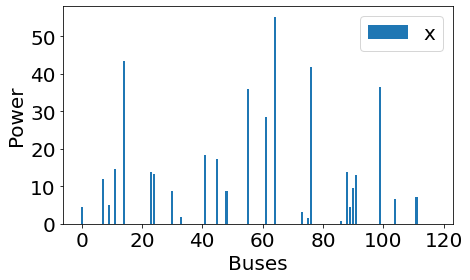

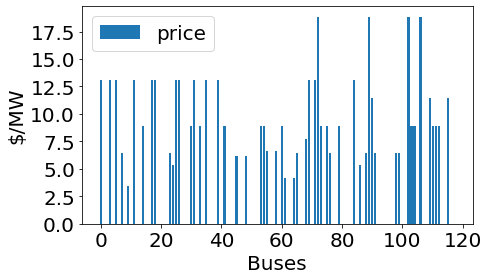

rp shape: (1, 118)
rp: 11.649971613145137


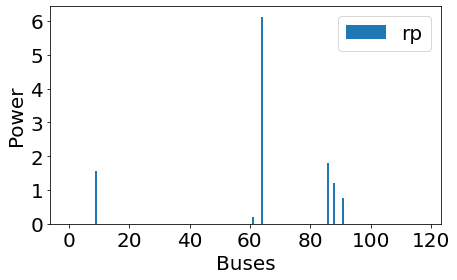

rd shape: (1, 118)
rd: -6.69573363103491e-07


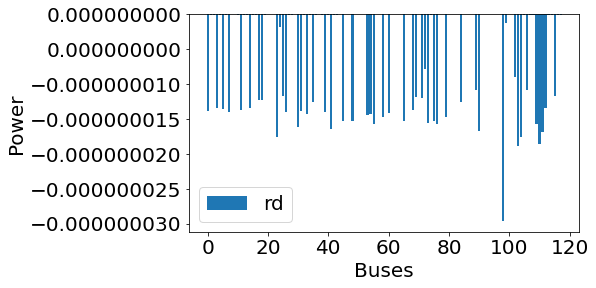

total cost [3021.9673118466158]
gen cost [2933.896413505998]
res cost [81.19892198093349]
recourse cost [6.871976359684161]
gen_penalties [3.1632959329772153e-13]


In [96]:
sanity_check(penalty_methodII_soln_results)
# sanity_check(penalty_methodII_soln_results_limit_flow)

### Evaluating

In [97]:
def eval(fname_to_open, fname_to_save):

    soln_results = json.load(open(Results_Path + fname_to_open, 'r'))

    eval_results, _ = solve_recourse(test_set[:1, :], common_MCscenarios, 
                                     soln_results, fname_to_save, return_rcsSolns=False)
    
    # sanity check
    eval_results = json.load(open(Results_Path + fname_to_save, 'r'))

    print(eval_results.keys())

    print('Evaluation results on test instances:')
    print("eval total cost", eval_results['evaluateTotalCost'])
    print("eval first-stage cost", eval_results['fsCost'])
    print("eval recourse cost", eval_results['rcsCost'])
    print("eval pos_res_cost", eval_results['pos_res_cost'])
    print("eval neg_res_cost", eval_results['neg_res_cost'])
    

if EVAL_PENALTY_METHODII:
    # eval('penalty_methodII_soln_K100_limit_flow', 'penalty_methodII_eval_limit_flow')
    eval('penalty_methodII_soln_K100', 'penalty_methodII_eval')

x_soln: (118, 1)
rp_soln: (118, 1)
rd_soln: (118, 1)
fsCost: (1,)
pos_res_cost shape: (1, 100)
recourse_cost shape: ()
Instance: 0 Problem status: optimal 
Evaluation tims for instance 0 is 0.03 minutes.
dict_keys(['Status', 'fsCost', 'rcsCost', 'evaluateTotalCost', 'pos_res_cost', 'neg_res_cost'])
Evaluation results on test instances:
eval total cost [42697.194823256956]
eval first-stage cost [1643.513045670023]
eval recourse cost [41053.681777586935]
eval pos_res_cost [4105.3681777586935]
eval neg_res_cost [0.0]


In [93]:
neural_solver_eval_results = json.load(open(Results_Path + 'neural_solver_eval', 'r'))
print(neural_solver_eval_results.keys())
print(neural_solver_eval_results['evaluateTotalCost'])

dict_keys(['Status', 'fsCost', 'rcsCost', 'evaluateTotalCost'])
[3223.1316438969975, 3116.6110483316406, 3145.0806544070715, 3183.359060804132, 3175.1238090859497, 3182.502445448652, 3104.740505718804, 3101.0661573663288, 3307.7091020254074, 3139.182784513401, 3173.587532306149, 3285.82021274716, 3266.582602059262, 3230.0236654844152, 3126.300561976192, 3218.6225007715234, 3125.9631645627574, 3252.924748382131, 3207.59597351517, 3216.9209868208723]


### Visualize

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


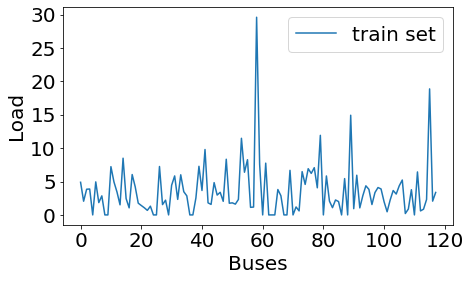

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


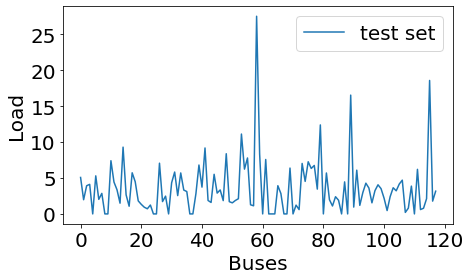

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


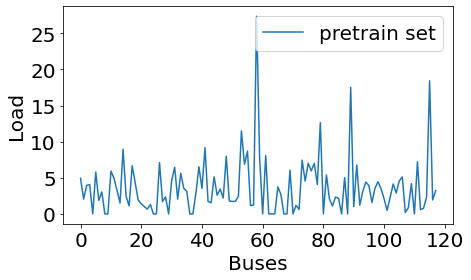

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


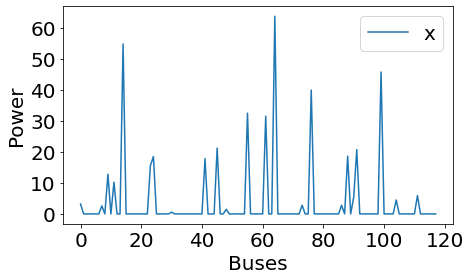

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


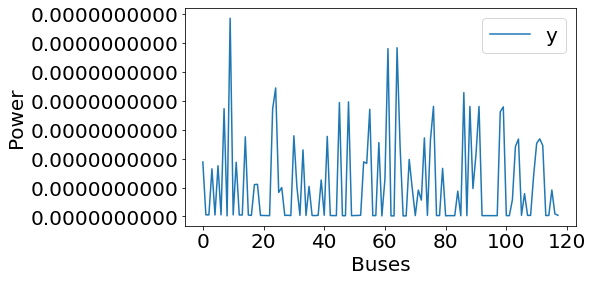

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


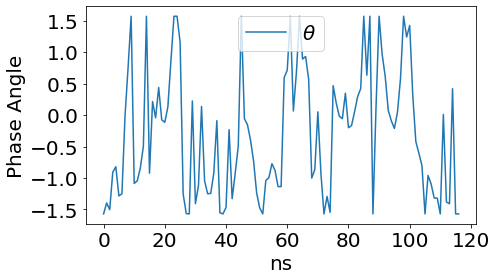

<ipython-input-21-94dc88053096>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


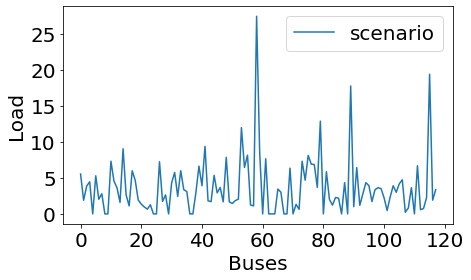

In [ ]:
visualize_bar(range(Num_Buses), train_set[10,:], 'train set', 'Buses', 'Load')
visualize_bar(range(Num_Buses), test_set[10,:], 'test set', 'Buses', 'Load')
visualize_bar(range(Num_Buses), pretrain_set[10,:], 'pretrain set', 'Buses', 'Load')

# pre_train_data1=[inputDemands, x_data, rp_data, rd_data]
# pre_train_data2=[net_load_data, y_data, theta_data]
i = Num_Buses
j = int(Num_Buses*2)
m = j+(Num_Buses-1)
visualize_bar(range(Num_Buses), pre_train_fs_data[10,i:j], 'x', 'Buses', 'Power')
visualize_bar(range(Num_Buses), pre_train_rcs_data[10,i:j], 'y', 'Buses', 'Power')
visualize_bar(range(Num_Buses-1), pre_train_rcs_data[10,j:m], r'$\theta$', 'ns', 'Phase Angle')

visualize_bar(range(Num_Buses), common_MCscenarios[0,:,10], 'scenario', 'Buses', 'Load')
 